In [99]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.pyplot import figure
from datetime import datetime, timedelta
from collections import OrderedDict 
import sys
import re
import math

In [100]:
# read file 'ktotal_contratos'
df_contratos = pd.read_csv('ktotal_contratos.csv')
# clean data
### format col names 
df_contratos.columns = df_contratos.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('\(', '_').str.replace('\)', '_')
### select and rename relevant cols
df_contratos = df_contratos[['no._carro','fecha_de_entrega_auto', 'fuente_del_contratacion']]
df_contratos = df_contratos.rename(columns={'no._carro': 'stockid', 'fecha_de_entrega_auto':'date_delivery', 'fuente_del_contratacion':'pago'})
### format date cols
df_contratos['date_delivery'] = pd.to_datetime(df_contratos['date_delivery'])
# examine data
print(df_contratos.shape)
print(set(df_contratos['pago']))
df_contratos.head()

(1284, 3)
set(['APP', 'FINANCIAMIENTO'])


,stockid,date_delivery,pago
0,13571,2019-11-24,APP
1,13139,2019-11-23,APP
2,16680,2019-11-25,APP
3,16151,2019-12-06,APP
4,17324,2020-01-20,APP


In [101]:
# read file 'entregas'
df_entregas = pd.read_csv("entregas.csv")
# clean data
### format col names
df_entregas.columns = df_entregas.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('\(', '_').str.replace('\)', '_')
### select and rename relevant cols
df_entregas = df_entregas[['estimate_asociado','auto', 'tipo_de_lugar_destino', 'fecha_de_entrega_agendada',
                           'hora', 'responsable_em_venta', 'método_de_pago']]
df_entregas = df_entregas.rename(columns={'estimate_asociado': 'estimate', 'auto':'stockid', 
                                          'tipo_de_lugar_destino':'location',
                                          'fecha_de_entrega_agendada':'date_delivery', 'hora':'hour', 
                                          'método_de_pago':'pago'})
### format and filter by date col
df_entregas['date_delivery'] = pd.to_datetime(df_entregas['date_delivery'],  dayfirst=True)
min_date = df_contratos['date_delivery'].min()
df_entregas = df_entregas[df_entregas['date_delivery'] >= min_date]
### format estimate col
df_entregas['estimate'] = df_entregas['estimate'].str[10:]
### format stockid col
def extr_stockid(auto):
    return re.findall('[\d]+', auto)[0]
df_entregas['stockid'] = df_entregas['stockid'].apply(extr_stockid)
# examine data
print(df_entregas.shape)
print(set(df_entregas['pago']))
df_entregas.head()

(9883, 7)
set([nan, 'Financiamiento', 'Pago de contado'])


,estimate,stockid,location,date_delivery,hour,responsable_em_venta,pago
4077,884663,15718,WH - LERMA,2019-11-02,9:00,Aneyda Cervantes,Financiamiento
4078,888086,15690,FLORENCIA,2019-11-02,9:30,Karen Garcia,Financiamiento
4079,902755,15384,WH - LERMA,2019-11-02,9:30,Ale Gonzalez,Pago de contado
4080,898547,14040,FLORENCIA,2019-11-02,10:00,Marco Nunez,Pago de contado
4081,882772,15290,FLORENCIA,2019-11-02,10:00,Aneyda Cervantes,Financiamiento


In [102]:
# Transform 'entregas' to include ktotal col
ktotal = np.zeros(len(df_entregas))
half_month = timedelta(days=15)
for i in range(len(df_contratos)):
    indcs = [ind for ind, x in enumerate(df_entregas['stockid']) 
               if int(x) == int(df_contratos['stockid'].iloc[i])]
    for j in indcs:
        if (((df_contratos['date_delivery'].iloc[i].date() -
             df_entregas['date_delivery'].iloc[j].date()) < half_month) &
            ((df_contratos['date_delivery'].iloc[i].date() -
             df_entregas['date_delivery'].iloc[j].date()) > -half_month)
           ):
            ktotal[j] = 1
df_entregas['ktotal'] = ktotal

2020-11-12 00:00:00


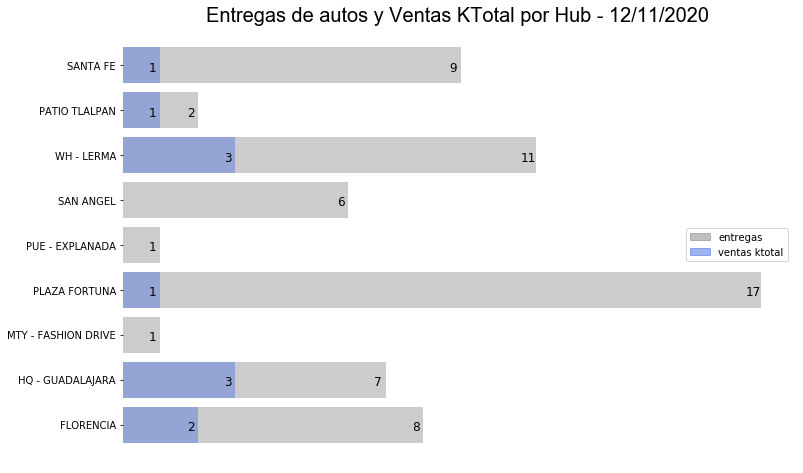

In [103]:
# Graph 1: Daily stacked bar chart
### find curr date
one_day = timedelta(days=1)
curr_day = pd.to_datetime(datetime.date(datetime.now())-one_day)
print(curr_day)
### filter data for curr day
df_curr_day = df_entregas[df_entregas['date_delivery']==curr_day]
### initialize dics
daily_entregas = {}
daily_total = {}
### find daily totals
for hub, frame in df_curr_day.groupby(['location']):
    daily_entregas[hub] = len(frame)
    daily_total[hub] = sum(frame['ktotal'])
### set x and y values: entregas
daily_entregas.pop('CASA CLIENTE')
x_entr = daily_entregas.keys()
y_entr = daily_entregas.values()
### set x and y values: ktotal
daily_total.pop('CASA CLIENTE')
x_tot = daily_total.keys()
y_tot = daily_total.values()
### overlay two barcharts
##### barchart entregas
figure(figsize=(12,8))
bar1 = plt.barh(x_entr, y_entr, alpha=.4, color="gray")
##### barchart ktotal
bar2 = plt.barh(x_tot, y_tot, alpha=.4, color="royalblue")
# format title, axes, and legend
titlestr = ('Entregas de autos y Ventas KTotal por Hub - ' + curr_day.strftime('%d/%m/%Y'))
plt.title(titlestr, fontsize=20, fontname="Arial")
gray_patch = mpatches.Patch(color='gray', label='entregas', alpha=.5)
blue_patch = mpatches.Patch(color='royalblue', label='ventas ktotal', alpha=.5)
plt.legend(handles=[gray_patch, blue_patch], loc=7)
plt.xticks([])
### label bars
def autolabel1(rects):
    for idx,rect in enumerate(bar1):
        plt.text(y_entr[idx]-.2, rect.get_y()+.35,
                y_entr[idx], fontsize=12,
                ha='center', va='center', rotation=0)
autolabel1(bar1)
def autolabel2(rects):
    for idx,rect in enumerate(bar2):
        if(y_tot[idx]==0): continue
        plt.text(y_tot[idx]-.2, rect.get_y()+.35,
                int(y_tot[idx]), fontsize=12,
                ha='center', va='center', rotation=0)
autolabel2(bar2)
### remove spines and tick marks
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().tick_params(bottom=False)
plt.savefig('daily_report.png')  

In [104]:
# Deliveries per hour
### find curr day, month, and year
curr_day = datetime.date(datetime.now()).day
curr_month = datetime.date(datetime.now()).month
curr_year = datetime.date(datetime.now()).year
print(str(curr_day) + "-" + str(curr_month) + "-" + str(curr_year))
print("\n")
### filter data by curr month + year
df_month = df_entregas[(df_entregas['date_delivery'].dt.month == curr_month) &
                      (df_entregas['date_delivery'].dt.year == curr_year) &
                      (df_entregas['date_delivery'].dt.day <= curr_day)]
### create day col
df_month['day'] = df_month['date_delivery'].dt.day
### find hourly delivery averages for each hub
for hub, frame in df_month.groupby(['location']):
    if(hub=='CASA CLIENTE'): continue
    print(hub)
    for hour, frame_hour in frame.groupby(['hour']):
        sumh = float(len(frame_hour))
        days = float(len(set(frame_hour['day'])))
        avg = round(float(sumh/days), 2)
        if(avg>1): print(hour + ": " + str(avg)) 
        else: continue
    print("\n")

13-11-2020


FLORENCIA
10:00: 1.33
10:30: 1.5
11:00: 1.2
12:00: 1.88
13:00: 1.25
15:00: 1.2
16:00: 1.5
17:00: 1.5
20:00: 2.0


HQ - GUADALAJARA
10:00: 1.67
12:00: 1.5
13:00: 1.17
16:00: 1.67
17:00: 1.5


HQ - LERMA


MTY - FASHION DRIVE


PATIO TLALPAN
11:00: 1.5
12:00: 1.4
13:00: 1.33
16:00: 1.33
17:00: 1.5


PLAZA FORTUNA
10:00: 1.2
11:00: 1.5
12:00: 2.0
14:00: 1.5
15:00: 1.6
16:00: 1.14
17:00: 1.17


PUE - EXPLANADA


SAN ANGEL
15:00: 1.33
16:00: 1.33


SANTA FE
12:00: 1.17
14:00: 3.0
15:00: 1.14
16:00: 1.5
17:00: 1.33


WH - LERMA
10:00: 1.4
11:00: 1.86
12:00: 2.13
13:00: 1.75
15:00: 1.5
16:00: 1.33
17:00: 1.57
18:00: 1.25
19:00: 1.5
19:45: 2.0




/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [105]:
# Divide population into two groups
### normalize pago col
df_contratos['pago'][df_contratos['pago']=='APP'] = 'C'
df_contratos['pago'][df_contratos['pago']=='FINANCIAMIENTO'] = 'F'
df_entregas['pago'][df_entregas['pago']=='Pago de contado'] = 'C'
df_entregas['pago'][df_entregas['pago']=='Financiamiento'] = 'F'
### remove nan from pago col in entregas
df_entregas_fin = df_entregas.loc[df_entregas['pago'].isin(['C', 'F'])]

/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/opt/anaconda2/lib/python2

In [106]:
# Transform 'entregas' to include pago verification col
verif = np.zeros(len(df_entregas_fin))
for i in range(len(df_contratos)):
    print(i)
    indcs = [ind for ind, x in enumerate(df_entregas_fin['stockid']) 
               if int(x) == int(df_contratos['stockid'].iloc[i])]
    for j in indcs:
        if (((df_contratos['date_delivery'].iloc[i].date() -
             df_entregas_fin['date_delivery'].iloc[j].date()) < half_month) &
            ((df_contratos['date_delivery'].iloc[i].date() -
             df_entregas_fin['date_delivery'].iloc[j].date()) > -half_month)
           ):
            if (df_contratos['pago'].iloc[i] == df_entregas_fin['pago'].iloc[j]):
                verif[j] = 1
df_entregas_fin['verif'] = verif





0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [108]:
float(sum(df_entregas_fin['verif']==1))/float(sum(df_entregas_fin['ktotal']==1))

0.6955484896661367